# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">REQUIREMENT</h1></span>

In [1]:
%%capture

!pip install sentence-transformers rank_bm25 numpy py_vncorenlp rouge_score bert_score vncorenlp evaluate

In [2]:
%%capture

!sudo apt-get update
!sudo apt-get install openjdk-8-jdk -y
!java -version

In [3]:
import numpy as np
from nltk.tokenize import word_tokenize
import pandas as pd
import os

# Thiết lập cho pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [4]:
%%capture

!sudo apt-get update
!sudo apt-get install openjdk-8-jdk -y
!java -version

In [5]:
!mkdir vncorenlp

In [6]:
%%capture

import py_vncorenlp

py_vncorenlp.download_model(save_dir='/kaggle/working/vncorenlp',)
nlp = py_vncorenlp.VnCoreNLP(save_dir='/kaggle/working/vncorenlp')

--2025-11-17 18:18:55--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.2.jar’

     0K .......... .......... .......... .......... ..........  0% 7.15M 4s
    50K .......... .......... .......... .......... ..........  0% 8.26M 3s
   100K .......... .......... .......... .......... ..........  0% 66.1M 2s
   150K .......... .......... .......... .......... ..........  0% 26.8M 2s
   200K .......... .......... .......... .......... ..........  0% 99.2M 2s
   250K .......... .......... .......... .......... ..........  1% 12.8M 2s
   300K .......... .......... .......... .......... ..........  1% 36.0M 2s
   350K ..

2025-11-17 18:18:59 INFO  WordSegmenter:24 - Loading Word Segmentation model
2025-11-17 18:18:59 INFO  PosTagger:23 - Loading POS Tagging model
2025-11-17 18:19:02 INFO  NerRecognizer:34 - Loading NER model
2025-11-17 18:19:16 INFO  DependencyParser:32 - Loading Dependency Parsing model


In [7]:
filename = "/kaggle/input/vietnamhistory-dataset/vietnamese-stopwords.txt"  # Điều chỉnh đường dẫn nếu cần

# Đọc stopwords từ file txt
with open(filename, 'r', encoding='utf-8') as f:
    list_stopwords = f.read().splitlines()

print(f"Số lượng stopwords đã tải: {len(list_stopwords)}")

Số lượng stopwords đã tải: 3884


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">MAIN</h1></span>

In [8]:
!pip install scikit-learn==1.7.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [9]:
from vncorenlp import VnCoreNLP
from collections import Counter
import math
from nltk.translate.bleu_score import SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import torch
import random

In [10]:
def set_SEED():
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(SEED)

set_SEED()

In [11]:
class StopwordRemover:
    def __init__(self, stopwords):
        self.stopwords = set(stopwords)

    def remove_stopwords(self, text):
        pre_text = []
        words = text.split()
        for word in words:
            if word.lower() not in self.stopwords:
                pre_text.append(word)
        return ' '.join(pre_text)
        
class VNPreprocessor:
    def __init__(self, nlp):
        self.nlp = nlp

    def preprocess(self, text):
        segmented_sentences = self.nlp.word_segment(text)
        processed_text = ' '.join(segmented_sentences)
        return processed_text
        
preprocessor = VNPreprocessor(nlp)
stopword_remover = StopwordRemover(list_stopwords)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">DOCUMENT CLASSIFICATION</h1></span>

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [13]:
df_train = pd.read_csv('/kaggle/input/vietnamhistory-dataset/train_data.csv')
df_val = pd.read_csv('/kaggle/input/vietnamhistory-dataset/valid_data.csv')
df_test = pd.read_csv('/kaggle/input/vietnamhistory-dataset/test_data.csv')


def processed_question (df):
    df['processed_question'] = df['question'].str.lower()
    df['processed_question'] = df['processed_question'].apply(preprocessor.preprocess)
    df['processed_question'] = df['processed_question'].apply(stopword_remover.remove_stopwords)
    return df
    
df_train = processed_question(df_train)
df_val = processed_question(df_val)
df_test = processed_question(df_test)

In [14]:
df_train.head()

,period,context,question,extractive answer,abstractive answer,processed_question
0,Giai đoạn 1951 - 1954,"Từ những ngày đầu của cuộc kháng chiến, Đảng và Chính phủ ban hành nhiều chính sách về ruộng đất nhằm mang lại những quyền lợi bước đầu cho nông dân. Tuy vậy, chính sách ruộng đất của Đảng và Chính phủ thực hiện trong những năm đầu kháng chiến chưa phải là cải cách ruộng đất triệt để, mà trước hết chỉ ""nhằm hạn chế sự bóc lột phong kiến"", tập trung giải quyết những vấn đề giảm tô, giảm tức, chia ruộng đất của thực dân Pháp và Việt gian cho nông dân nghèo, sử dụng hợp lý ruộng đất vắng chủ, ruộng đất bỏ hoang, chia công điền công thổ, phát động phong trào hiến điền, thực hiện chính sách thuế công bằng dân chủ.",Chính sách ruộng đất trong những năm đầu kháng chiến có phải là cải cách ruộng đất triệt để không và mục tiêu trước mắt là gì?,"Chưa phải là cải cách ruộng đất triệt để, mà trước hết chỉ ""nhằm hạn chế sự bóc lột phong kiến"".","Chính sách ruộng đất giai đoạn đầu chưa phải là cải cách triệt để, mà trước mắt chỉ nhằm mục tiêu hạn chế sự bóc lột của chế độ phong kiến.",chính_sách ruộng_đất đầu kháng_chiến cải_cách_ruộng_đất triệt_để mục_tiêu trước_mắt ?
1,Giai đoạn 1951 - 1954,Kết quả là số thu năm 1952 đã đảm bảo được 78% số chi và năm 1953 lần đầu tiên kể từ Cách mạng tháng Tám số thu chẳng những hoàn toàn đảm bảo số chi mà còn vượt số chi tới 16%.,Tỷ lệ thu đảm bảo chi năm 1952 là bao nhiêu?,Số thu năm 1952 đã đảm bảo được 78% số chi.,"Năm 1952, số thu ngân sách đã đảm bảo được 78% tổng chi tiêu.",tỷ_lệ thu chi 1952 ?
2,Giai đoạn 1951 - 1954,"Tại Nam Bộ: Trước nguy cơ suy sụp ngày càng gia tăng của thực dân Pháp, đế quốc Mỹ nhanh chóng tranh thủ thời cơ bắt đầu thực hiện âm mưu trực tiếp can thiệp sâu vào Đông Dương. Các chuyến tàu viện trợ quân sự của Mỹ cập bến Sài Gòn ngày càng nhiều. Đối với miền Đông Nam Bộ, nỗ lực hoạt động của địch nằm trong phạm vi thực hiện chủ trương, phối hợp tiến công bằng cả kinh tế, chính trị, quân sự nhằm đánh mạnh vào lực lượng du kích, chiến lược chiến tranh du kích của ta, cướp vét và tận dụng dự trữ, thực hiện chính sách ""lấy chiến tranh nuôi chiến tranh"" và bao vây cô lập khu 7 bằng cách ngăn chặn, kiểm soát chặt chẽ khu 8... Từ đầu năm 1951 trở đi, địch ráo riết thiết lập các điểm chốt chặn trên dọc hành lang Đức Hòa - Hóc Môn, kiểm soát chặt đường biển, đường sông Vàm Cỏ, đường số 10 và số 1, cắt đứt đường giao thông tiếp viện của ta từ miền Tây lên miền Đông; tăng cường lực lượng bảo vệ các đường giao thông chiến lược nối thông với Tây Nguyên (đường 14, 20), với cực Nam Trung Bộ (đường 1 và đường xe lửa).","Từ đầu năm 1951, Pháp đã thực hiện những biện pháp nào để kiểm soát giao thông và tiếp viện của Việt Minh ở Nam Bộ?","Địch ráo riết thiết lập các điểm chốt chặn trên dọc hành lang Đức Hòa - Hóc Môn, kiểm soát chặt đường biển, đường sông Vàm Cỏ, đường số 10 và số 1, cắt đứt đường giao thông tiếp viện của ta từ miền Tây lên miền Đông.","Pháp lập nhiều chốt chặn ở hành lang Đức Hòa - Hóc Môn, kiểm soát gắt gao đường biển, sông Vàm Cỏ, quốc lộ 1 và 10 nhằm cắt đứt đường tiếp vận của Việt Minh từ Tây lên Đông Nam Bộ.","đầu 1951 , pháp biện_pháp kiểm_soát giao_thông tiếp_viện việt minh nam_bộ ?"
3,Giai đoạn 1945 - 1950,"Ở một số địa phương, bệnh hoa liễu phát triển mạnh do vệ sinh kém, tệ nạn gái mại dâm khá phổ biến. Ngoài ra là các bệnh sốt rét, tả, thương hàn cũng thường xảy ra, đặc biệt là ở những vùng miền núi và vùng nông thôn. Ở những nơi đó tình trạng y tế hết sức kém cỏi, người dân thiếu kiến thức về vệ sinh, phòng và chữa bệnh, cơ sở y tế, dụng cụ y tế quá ít, quá lạc hậu, thuốc men không đủ cho những vùng xa xôi, khiến cho người dân trông chờ vào cúng vái và chủ yếu dùng thuốc nam, lá cây cỏ để chữa bệnh. Phần lớn các làng không có trạm xá, không có y tá để chăm sóc sức khỏe cho nhân dân. Thường thường phải vài ba làng mới có một trạm xá, một y tá, một nhà hộ sinh và một bà mụ đỡ đẻ với một số thiết bị y tế hết sức đơn giản và một số loại thuốc chữa bệnh thông thườ

In [15]:
df_combine = pd.concat([df_train, df_val])

label_encoder = LabelEncoder()
df_combine['period_encoded'] = label_encoder.fit_transform(df_combine['period'])
df_test['period_encoded'] = label_encoder.transform(df_test['period'])

X_train = df_combine['processed_question']
X_test = df_test['processed_question']
y_train = df_combine['period_encoded']
y_test = df_test['period_encoded']

print("Data preprocessing completed!")

Data preprocessing completed!


In [16]:
X_train.head()

0    chính_sách ruộng_đất đầu kháng_chiến cải_cách_ruộng_đất triệt_để mục_tiêu trước_mắt ?
1                                                                     tỷ_lệ thu chi 1952 ?
2              đầu 1951 , pháp biện_pháp kiểm_soát giao_thông tiếp_viện việt minh nam_bộ ?
3                        bệnh phát_triển địa_phương vệ_sinh kém tệ_nạn mại_dâm 1948-1950 ?
4                  thành_tựu xây_dựng hệ_thống tài_chính - ngân_hàng giai_đoạn 1950-1951 ?
Name: processed_question, dtype: object

=== Thống Kê Độ Dài cho Train Set ===
Số lượng mẫu: 9109
Độ dài tối thiểu: 1
Độ dài tối đa: 22
Độ dài trung bình: 7.45
Độ dài trung vị (Median): 7.0
25th percentile: 6.0
75th percentile: 9.0
90th percentile: 11.0
95th percentile: 12.0
99th percentile: 14.0




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


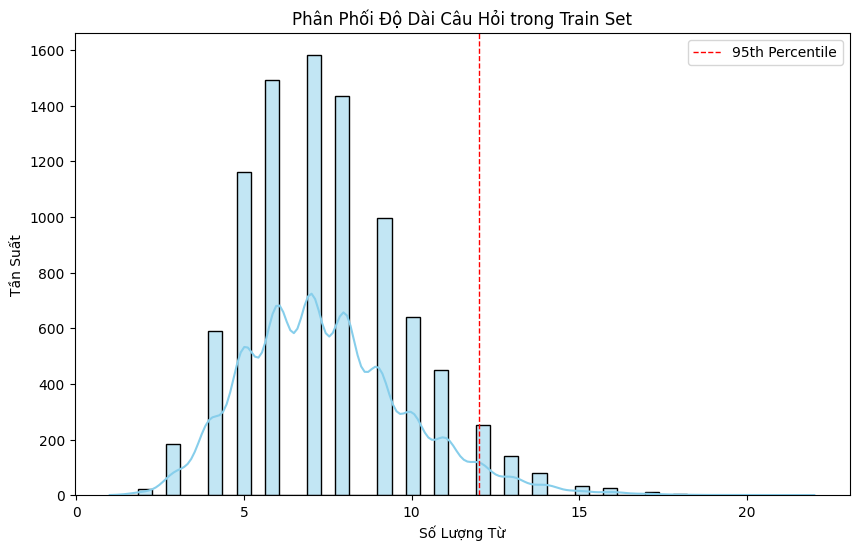

=== Thống Kê Độ Dài cho Test Set ===
Số lượng mẫu: 1608
Độ dài tối thiểu: 2
Độ dài tối đa: 21
Độ dài trung bình: 7.50
Độ dài trung vị (Median): 7.0
25th percentile: 6.0
75th percentile: 9.0
90th percentile: 11.0
95th percentile: 12.0
99th percentile: 15.0




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


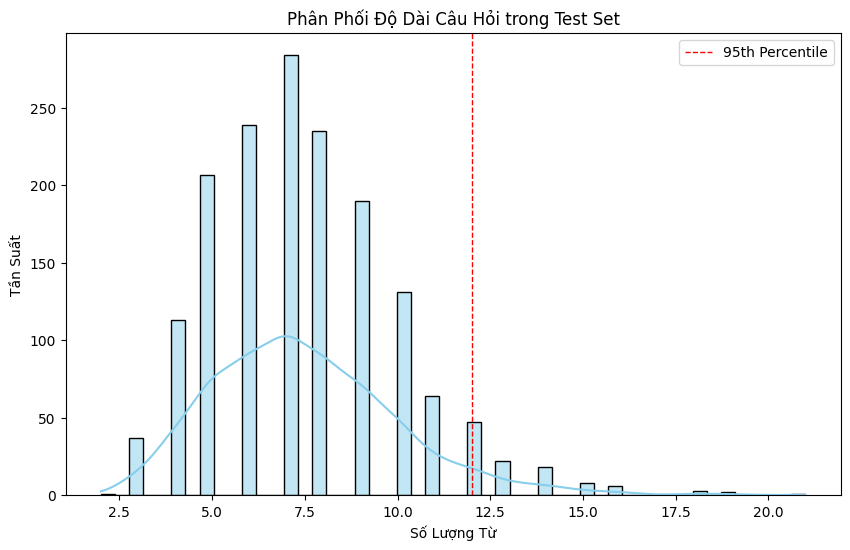

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_lengths(df, set_name):
    # Tính độ dài dựa trên số lượng từ
    lengths = df['processed_question'].apply(lambda x: len(x.split()))

    # Hiển thị các thống kê cơ bản
    print(f"=== Thống Kê Độ Dài cho {set_name} ===")
    print(f"Số lượng mẫu: {len(lengths)}")
    print(f"Độ dài tối thiểu: {lengths.min()}")
    print(f"Độ dài tối đa: {lengths.max()}")
    print(f"Độ dài trung bình: {lengths.mean():.2f}")
    print(f"Độ dài trung vị (Median): {lengths.median()}")
    print(f"25th percentile: {lengths.quantile(0.25)}")
    print(f"75th percentile: {lengths.quantile(0.75)}")
    print(f"90th percentile: {lengths.quantile(0.90)}")
    print(f"95th percentile: {lengths.quantile(0.95)}")
    print(f"99th percentile: {lengths.quantile(0.99)}")
    print("\n")

    # Vẽ biểu đồ phân phối độ dài
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=50, kde=True, color='skyblue')
    plt.title(f'Phân Phối Độ Dài Câu Hỏi trong {set_name}')
    plt.xlabel('Số Lượng Từ')
    plt.ylabel('Tần Suất')
    plt.axvline(lengths.quantile(0.95), color='red', linestyle='dashed', linewidth=1, label='95th Percentile')
    plt.legend()
    plt.show()

analyze_lengths(df_combine, 'Train Set')

analyze_lengths(df_test, 'Test Set')


In [18]:
import pandas as pd
from collections import Counter

# Chuyển đổi y_train thành Series để dễ dàng tính toán tần suất
y_train_series = pd.Series(y_train)
class_counts = Counter(y_train)
total_samples = len(y_train)

print("### Phân Bố Lớp trên Tập Train ###")
for label, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Lớp {label}: {count} mẫu ({percentage:.2f}%)")

# Nếu số lượng lớp lớn, bạn có thể chỉ cần in số lượng lớp
num_classes = len(class_counts)
print(f"\nTổng số lượng lớp: {num_classes}")

### Phân Bố Lớp trên Tập Train ###
Lớp 1: 1289 mẫu (14.15%)
Lớp 0: 994 mẫu (10.91%)
Lớp 3: 4090 mẫu (44.90%)
Lớp 2: 2736 mẫu (30.04%)

Tổng số lượng lớp: 4


### <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">1. Tuning TF-IDF, SVC</h1></span>

In [19]:
import optuna
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

### Tối ưu TF-IDF ###
# def objective_tfidf(trial):
#     # Chuyển đổi ngram_range thành định dạng hợp lệ
#     ngram_range_index = trial.suggest_categorical("ngram_range_index", [1, 2, 3])
#     ngram_range = (1, ngram_range_index)

#     # Tham số TF-IDF cần tối ưu
#     max_features = trial.suggest_int("max_features", 5000, 20000)
#     max_df = trial.suggest_float("max_df", 0.95, 1.0)
#     min_df = trial.suggest_float("min_df", 0.0, 0.00001)
#     sublinear_tf = trial.suggest_categorical("sublinear_tf", [True, False])

#     # Vector hóa dữ liệu
#     tfidf = TfidfVectorizer(
#         max_features=max_features,
#         ngram_range=ngram_range,
#         max_df=max_df,
#         min_df=min_df,
#         sublinear_tf=sublinear_tf,
#         token_pattern=r"(?u)\b\w+\b"
#     )
#     X_train_tfidf = tfidf.fit_transform(X_train)
#     X_test_tfidf = tfidf.transform(X_test)

#     # Sử dụng SVM mặc định để đánh giá
#     svm_model = SVC(kernel="linear", random_state=42)
#     svm_model.fit(X_train_tfidf, y_train)
#     y_pred = svm_model.predict(X_test_tfidf)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy

# # Tìm siêu tham số TF-IDF tốt nhất
# study_tfidf = optuna.create_study(direction="maximize")
# study_tfidf.optimize(objective_tfidf, n_trials=100, n_jobs=-1)

# # Lấy tham số TF-IDF tốt nhất
# best_tfidf_params = study_tfidf.best_params
# print("Best TF-IDF Parameters:", best_tfidf_params)

# # Tạo TF-IDF với tham số tối ưu
# best_ngram_range = (1, best_tfidf_params["ngram_range_index"])
# tfidf = TfidfVectorizer(
#     max_features=best_tfidf_params["max_features"],
#     ngram_range=best_ngram_range,
#     max_df=best_tfidf_params["max_df"],
#     min_df=best_tfidf_params["min_df"],
#     sublinear_tf=best_tfidf_params["sublinear_tf"],
#     token_pattern=r"(?u)\b\w+\b"
# )
# X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)

# ### Tối ưu SVM ###
# def objective_svm(trial):
#     # Tham số cần tối ưu cho SVM
#     C = trial.suggest_float("C", 1e-3, 1e2, log=True)
#     kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
#     gamma = "scale" if kernel == "linear" else trial.suggest_categorical("gamma", ["scale", "auto"])
#     class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

#     # Định nghĩa mô hình SVM
#     svm_model = SVC(
#         C=C,
#         kernel=kernel,
#         gamma=gamma,
#         class_weight=class_weight,
#         random_state=42
#     )
    
#     # Sử dụng Stratified K-Fold Cross-Validation (5 folds)
#     # Stratified đảm bảo tỷ lệ lớp được giữ nguyên trong mỗi fold
#     cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
#     # Tính điểm CV, sử dụng độ chính xác làm metric
#     scores = cross_val_score(
#         svm_model, 
#         X_train_tfidf, # Dữ liệu train đã được TF-IDF
#         y_train,       # Nhãn train
#         cv=cv_strategy, 
#         scoring="accuracy",
#         n_jobs=-1
#     )
    
#     # Optuna sẽ tìm kiếm để tối đa hóa điểm trung bình của CV
#     mean_accuracy = np.mean(scores)
#     return mean_accuracy
    
# # Tìm siêu tham số tốt nhất cho SVM
# study_svm = optuna.create_study(direction="maximize")
# study_svm.optimize(objective_svm, n_trials=100, n_jobs=-1)

# # Tham số tốt nhất cho SVM
# best_svm_params = study_svm.best_params
# print("Best SVM Parameters:", best_svm_params)

# # Huấn luyện SVM với tham số tối ưu
# best_svm = SVC(
#     C=best_svm_params["C"],
#     kernel=best_svm_params["kernel"],
#     gamma=best_svm_params.get("gamma", "scale"),
#     class_weight=best_svm_params["class_weight"],
#     random_state=42
# )
# best_svm.fit(X_train_tfidf, y_train)

# # Đánh giá trên tập test
# y_pred = best_svm.predict(X_test_tfidf)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)


In [20]:

best_tfidf_params = {'ngram_range_index': 3, 'max_features': 19447, 'max_df': 0.9674038007670736, 'min_df': 1.906453987123285e-08, 'sublinear_tf': True}

# Tạo TF-IDF với tham số tối ưu
best_ngram_range = (1, best_tfidf_params["ngram_range_index"])
tfidf = TfidfVectorizer(
    max_features=best_tfidf_params["max_features"],
    ngram_range=best_ngram_range,
    max_df=best_tfidf_params["max_df"],
    min_df=best_tfidf_params["min_df"],
    sublinear_tf=best_tfidf_params["sublinear_tf"],
    token_pattern=r"(?u)\b\w+\b"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

best_svm_params = {'C': 1.772057639964956, 'kernel': 'linear', 'class_weight': None}

# Huấn luyện SVM với tham số tối ưu
best_svm = SVC(
    **best_svm_params,
    random_state=42,
    probability=True
)
best_svm.fit(X_train_tfidf, y_train)

# Đánh giá trên tập test
y_pred = best_svm.predict(X_test_tfidf)
print("SVM Results on Test Data:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


SVM Results on Test Data:
Accuracy: 0.8072139303482587
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       176
           1       0.81      0.74      0.78       227
           2       0.78      0.75      0.76       483
           3       0.81      0.87      0.84       722

    accuracy                           0.81      1608
   macro avg       0.82      0.79      0.81      1608
weighted avg       0.81      0.81      0.81      1608



In [21]:
import joblib

joblib.dump(best_svm, "best_svm.pkl")
joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [22]:
!zip -r model_files.zip best_svm.pkl tfidf.pkl label_encoder.pkl

  adding: best_svm.pkl (deflated 40%)
  adding: tfidf.pkl (deflated 75%)
  adding: label_encoder.pkl (deflated 36%)


In [23]:
%%capture

import pandas as pd

top_k_svm = 1

# Dự đoán xác suất
y_proba_svm = best_svm.predict_proba(X_test_tfidf)
labels = best_svm.classes_

# Kết hợp nhãn và phần trăm xác suất, chỉ lấy top k
y_pred_svm_topk = [
    dict(sorted(zip(labels, probs), key=lambda x: x[1], reverse=True)[:top_k_svm])
    for probs in y_proba_svm
]

# Chuyển đổi phần trăm và hiển thị
y_pred_svm_topk = [
    {label: round(prob * 100, 2) for label, prob in sample.items()}
    for sample in y_pred_svm_topk
]

# Hiển thị kết quả
for i, pred in enumerate(y_pred_svm_topk):
    print(f"Sample {i+1}: {pred}")

In [24]:
def calculate_topk_accuracy(y_pred_topk, y_test, k):
    """
    Tính accuracy của y_pred_topk với y_test dựa trên tiêu chí top k nhãn.

    Args:
        y_pred_topk (list of dict): Danh sách các từ điển chứa nhãn và xác suất (top k).
        y_test (list): Danh sách nhãn thực sự.
        k: Top k nhãn
    Returns:
        float: Accuracy dựa trên top k nhãn.
    """
    correct = 0
    total = len(y_test)

    for i, true_label in enumerate(y_test):
        predicted_labels = list(y_pred_topk[i].keys())  # Lấy danh sách nhãn dự đoán (top 2)
        if true_label in predicted_labels:
            correct += 1

    return correct / total

# Tính accuracy
accuracy = calculate_topk_accuracy(y_pred_svm_topk, y_test, top_k_svm)
print(f"Top-{top_k_svm} Accuracy: {accuracy * 100:.2f}%")

Top-1 Accuracy: 80.53%


### <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">2. Document Predictor</h1></span>

In [25]:
class PredictTopK:
    def __init__(self, model, vectorizer, label_encoder, k=1):
        self.model = model
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder
        self.k = k

    def predict(self, input_text):
        # text preprocessing
        processed = input_text.lower()
        processed = preprocessor.preprocess(processed)
        processed = stopword_remover.remove_stopwords(processed)

        encoded = self.vectorizer.transform([processed])
        proba = self.model.predict_proba(encoded)[0]

        top_k_idx = np.argsort(proba)[-self.k:][::-1]
        labels = self.label_encoder.inverse_transform(top_k_idx)

        return labels.tolist()


# Tạo đối tượng dự đoán
predictor = PredictTopK(best_svm, tfidf, label_encoder, k=1)

# Văn bản cần dự đoán
input_text = "Ý nghĩa của những yếu tố trong cuộc kháng chiến chống Mỹ?"

# Dự đoán top 2 nhãn gốc
print(predictor.predict(input_text))


['Giai đoạn 1965 -1975']


In [26]:
df_ex = df_test['question']

for i in range (0, 10):
    print(f"câu hỏi {i}: {df_ex[i]}")
    print(predictor.predict(df_ex[i]))

câu hỏi 0: Nhân dân Việt Nam đã đánh thắng quân đội Pháp dựa trên những yếu tố nào?
['Giai đoạn 1945 - 1950']
câu hỏi 1: Nhân dân Tây Bắc đã đóng góp như thế nào cho tiền tuyến Điện Biên Phủ?
['Giai đoạn 1951 - 1954']
câu hỏi 2: Sắc lệnh số 27/SL ngày 10-9-1945 quy định thành lập cơ quan thuế nào?
['Giai đoạn 1945 - 1950']
câu hỏi 3: Anh hùng Ngô Gia Khảm đã thể hiện tinh thần hy sinh và cống hiến như thế nào?
['Giai đoạn 1954 -1965']
câu hỏi 4: Kể tên một số chiến dịch hoặc hoạt động quân sự tiêu biểu ở các chiến trường khác nhằm phối hợp với chiến dịch Biên giới?
['Giai đoạn 1945 - 1950']
câu hỏi 5: Tháng 4-1947, Chủ tịch Hồ Chí Minh bày tỏ hy vọng gì trong thư gửi nhân dân Mỹ?
['Giai đoạn 1945 - 1950']
câu hỏi 6: Trong kháng chiến, công nghiệp chủ yếu phát triển dưới hình thức nào và nhằm mục đích gì?
['Giai đoạn 1951 - 1954']
câu hỏi 7: Quân Pháp rút khỏi Bắc Kạn vào thời điểm nào năm 1949?
['Giai đoạn 1945 - 1950']
câu hỏi 8: Sau thắng lợi Việt Bắc Thu - Đông 1947, quân dân Việt N